In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,os,datetime

import tensorflow as tf
import pandas as pd
from sklearn import preprocessing as pp
import seaborn as sns

from keras.models import Model,Sequential
from keras.layers import Dense,Dropout,LSTM,Conv2D,Conv2DTranspose,MaxPooling2D,UpSampling2D,Input,BatchNormalization,Flatten

warnings.filterwarnings('ignore')
sns.set()

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
lookback_days = 25
forecast_days = 10

df = pd.read_csv('Data\\data1\\all_stocks_5yr.csv',infer_datetime_format=True)

In [3]:
ticker_list = list(set(df['Name'].values))

names = []
ind = []

for k in range(len(ticker_list)):
    ticker = df[df['Name']==ticker_list[k]].sort_values(by='date')['close'].values
    if ticker.shape[0]!=1259: continue
    names.append(ticker_list[k])
    ind.append(ticker)

tickers = np.vstack(ind)
dtickers = np.diff(tickers,axis=1)

dfT = pd.DataFrame(data=tickers,index=None)
dfD = pd.DataFrame(data=dtickers,index=None)

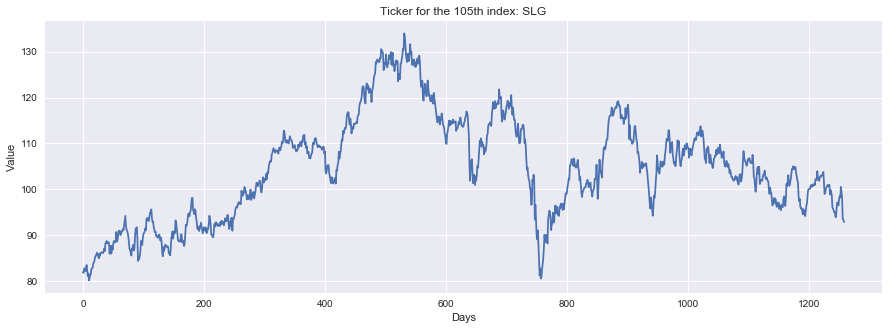

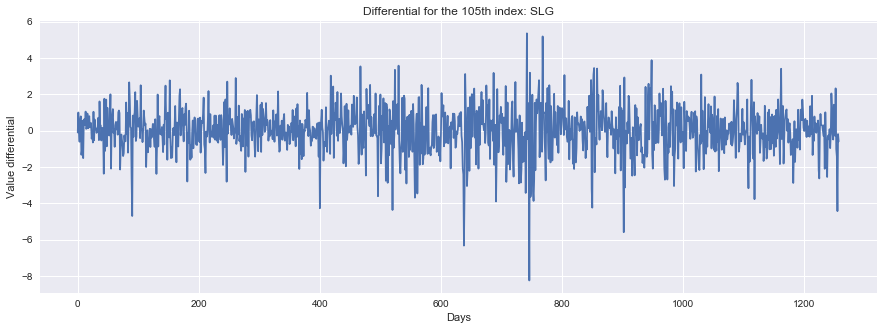

In [4]:
example_index = 105

fig = plt.figure(figsize=(15,5))
plt.plot(tickers[example_index,:])
plt.title('Ticker for the %dth index: %s'%(example_index,names[example_index]))
plt.xlabel('Days')
plt.ylabel('Value')
plt.show()

fig = plt.figure(figsize=(15,5))
plt.plot(dtickers[example_index,:])
plt.title('Differential for the %dth index: %s'%(example_index,names[example_index]))
plt.xlabel('Days')
plt.ylabel('Value differential')
plt.show()

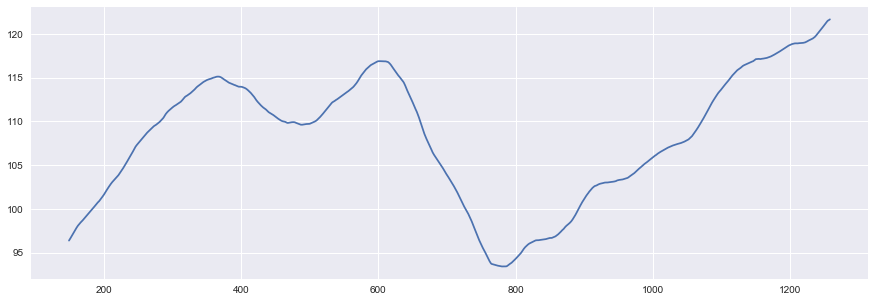

In [5]:
dfT.loc[1].rolling(150).mean().plot(figsize=(15,5))

In [6]:
def gen_autoenc(tickers,lookback_days,batch_size=5,randomize=True):
    indices = np.arange(lookback_days,tickers.shape[1])
    if randomize:
        indices = rnd.permutation(indices)
    while True:
        for k in range(indices.shape[0]):
            if tickers.shape[0]-k<batch_size:
                break
            data = np.zeros(shape=[batch_size,tickers.shape[0],lookback_days])
            for kk in range(batch_size):
                data[kk,:,:] = tickers[:,indices[kk]-lookback_days:indices[kk]]
            data = np.expand_dims(data,axis=3)
            yield data,data

In [227]:
gen = gen_autoenc(dtickers,lookback_days=lookback_days)

in0 = Input(shape=(470,25,1))
in1 = Input(shape=(232,10,25))

conv0 = Conv2D(filters=128,kernel_size=(5,5),strides=(2,2),activation='tanh')(in0)
dropout0 = Dropout(0.1)(conv0)
dense0 = Dense(units=64,activation='tanh')(dropout0)
dense1 = Dense(units=lookback_days,activation='tanh')(dense0)

dense2 = Dense(units=lookback_days,activation='tanh')(dense1)
dense3 = Dense(units=64,activation='tanh')(dense2)
dropout1 = Dropout(0.1)(dense3)
deconv1 = Conv2DTranspose(filters=1,kernel_size=(6,5),strides=(2,2),activation='tanh')(dropout1)

model = Model(in0,deconv1)
enc = Model(in0,dense1)

dec_layer0 = model.layers[-4](in1)
dec_layer1 = model.layers[-3](dec_layer0)
dec_layer2 = model.layers[-1](dec_layer1)

dec = Model(in1,dec_layer2)

model.compile(optimizer='RMSProp',loss='mse',metrics=['accuracy'])

In [228]:
model.fit_generator(gen,steps_per_epoch=200,epochs=2`)

Epoch 1/15
2000/2000 [==============================] - 339s 170ms/step - loss: 2.8913 - acc: 0.0127
Epoch 2/15
2000/2000 [==============================] - 345s 173ms/step - loss: 2.8684 - acc: 0.0129
Epoch 3/15
2000/2000 [==============================] - 384s 192ms/step - loss: 2.8661 - acc: 0.0130
Epoch 4/15
2000/2000 [==============================] - 346s 173ms/step - loss: 2.8653 - acc: 0.0130
Epoch 5/15
2000/2000 [==============================] - 389s 194ms/step - loss: 2.8650 - acc: 0.0130
Epoch 6/15
2000/2000 [==============================] - 391s 195ms/step - loss: 2.8649 - acc: 0.0130
Epoch 7/15
2000/2000 [==============================] - 356s 178ms/step - loss: 2.8647 - acc: 0.0130
Epoch 8/15
2000/2000 [==============================] - 401s 200ms/step - loss: 2.8646 - acc: 0.0130
Epoch 9/15
2000/2000 [==============================] - 364s 182ms/step - loss: 2.8645 - acc: 0.0130
Epoch 10/15
2000/2000 [==============================] - 368s 184ms/step - loss: 2.8644 - a

In [181]:
x = next(gen)[0]

In [183]:
x.shape

(5, 470, 25, 1)

In [184]:
encodedX = enc.predict(x)

In [186]:
encodedX.shape

(5, 232, 10, 25)